In [432]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [433]:
# Parameters (EC5)
m = 0.068 # (Kg)
g = 9.81 #(m/s^2)
k = 2*3.2654e-5 #(Nm^2/A^2) 
R = 1         # resistência (Ohm)
epsilon = 0.03
# Ponto de equilíbrio
x0 = 7.3e-3                                      # posição de equilíbrio (m)
i0 = 1.0                                         # corrente de equilíbrio (A)
u0 = R * i0                                      # tensão de equilíbrio (V)


print(f"Corrente de equilíbrio i0 = {i0:.4f} A")
print(f"Tensão de equilíbrio u0 = {u0:.4f} V")

Corrente de equilíbrio i0 = 1.0000 A
Tensão de equilíbrio u0 = 1.0000 V


In [434]:
# Força magnética
def f_m(i, x):
    return (k/2) * (i**2/x**2)

# Fator Bl
def Bl(i, x):
    return f_m(i,x)/i

# Indutância (assumida constante)
def L(x):
    return 0.01  # H


In [435]:
# Ganhos do PID
Kp = 190
Ki = 20
Kd = 20

# Função do sistema dinâmico com controle PID
def f(t, y):
    i, x, v, E = y  # corrente, posição, velocidade, erro acumulado
    e = x - x0      # erro de posição
    der_e = v       # derivada do erro (dx/dt)
    int_e = E       # integral do erro acumulado

    delta_u = Kp * e + Ki * int_e + Kd * der_e
    u = u0 + delta_u
    
    i = np.clip(i, 0, 2)  # Limitar a corrente entre 0 e 2 A
    

    di_dt = (u - R * i - Bl(i, x) * v) / L(x)
    dx_dt = v
    dv_dt = g - f_m(i, x) / m
    dE_dt = e

    return [di_dt, dx_dt, dv_dt, dE_dt]


In [436]:
# Condições iniciais

y0 = [i0, x0, 0.0, 0.0]  # [corrente, posição, velocidade, erro acumulado]
t0, tf = 0, 30           # intervalo de simulação
t_eval = np.linspace(t0, tf, 1000)

# Simulação numérica com Runge-Kutta 4(5)
sol = solve_ivp(f, (t0, tf), y0, t_eval=t_eval)

# Extração dos resultados
t = sol.t
i = sol.y[0]
x = sol.y[1]
v = sol.y[2]


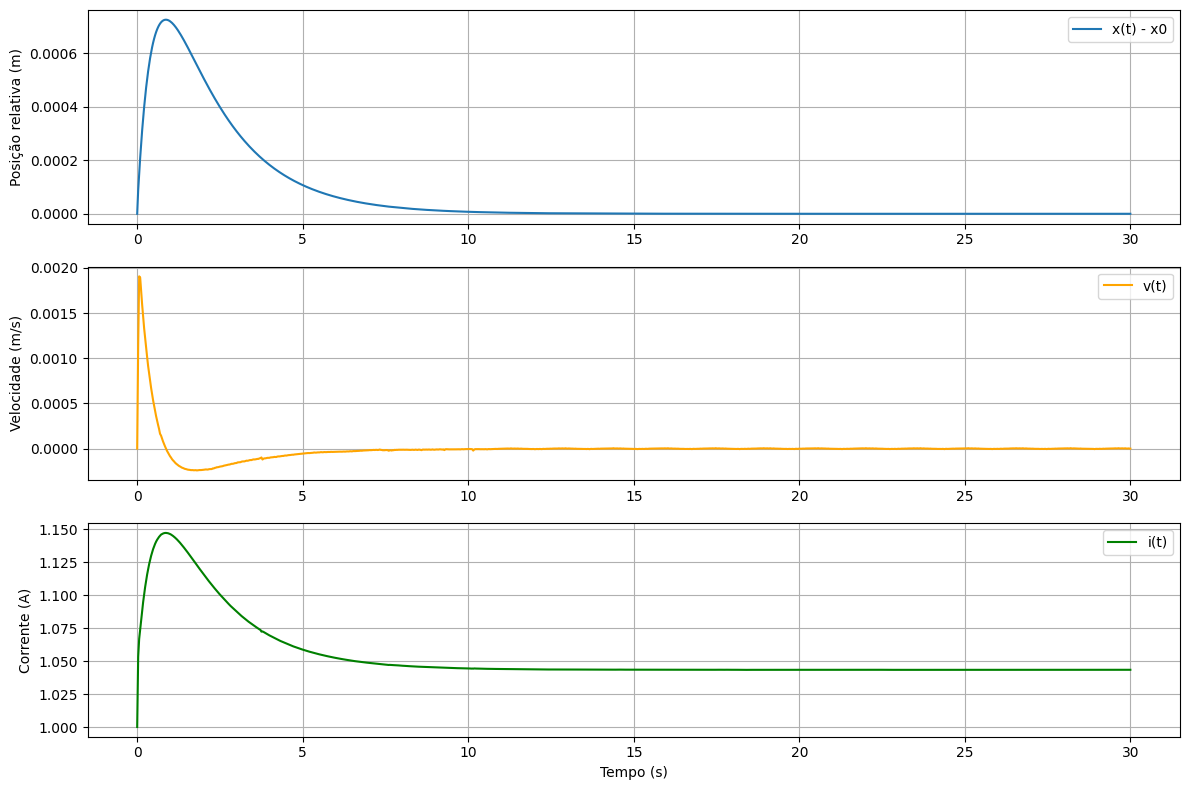

In [437]:
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(t, x - x0, label='x(t) - x0')
plt.ylabel('Posição relativa (m)')
plt.grid()
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(t, v, label='v(t)', color='orange')
plt.ylabel('Velocidade (m/s)')
plt.grid()
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(t, i, label='i(t)', color='green')
plt.xlabel('Tempo (s)')
plt.ylabel('Corrente (A)')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


#### Avaliação de estabilidade de acordo com epsilon(+erro%)

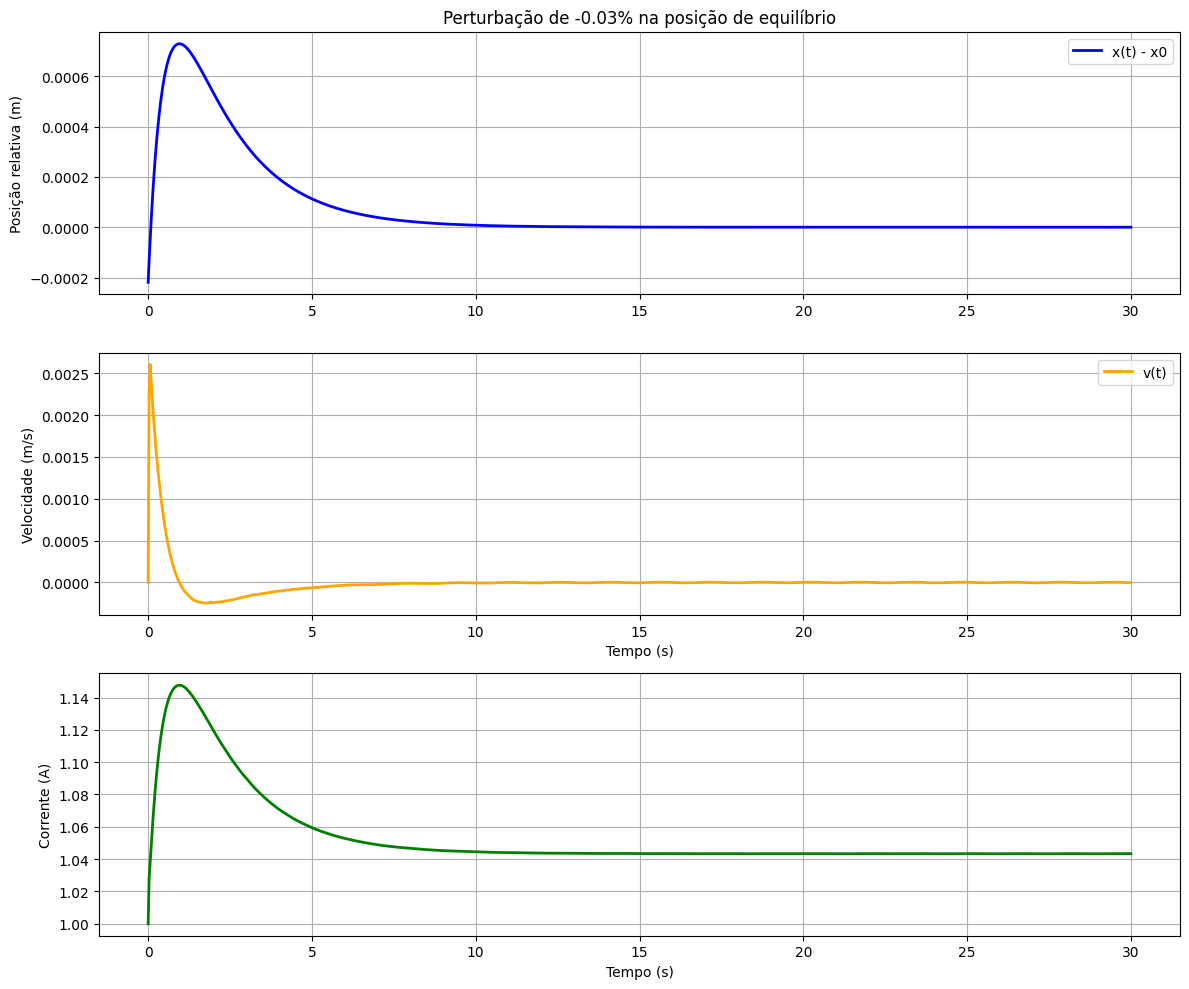

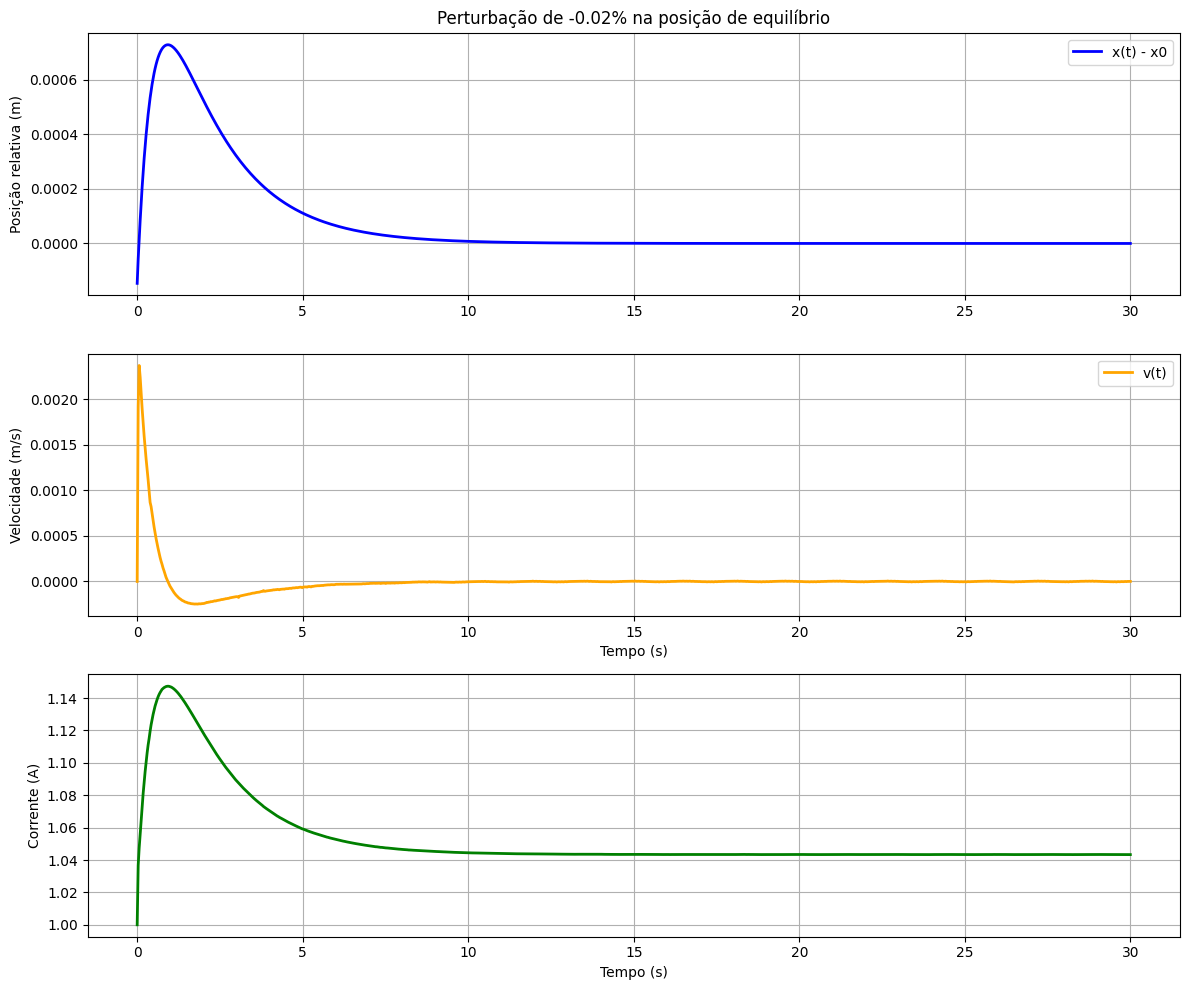

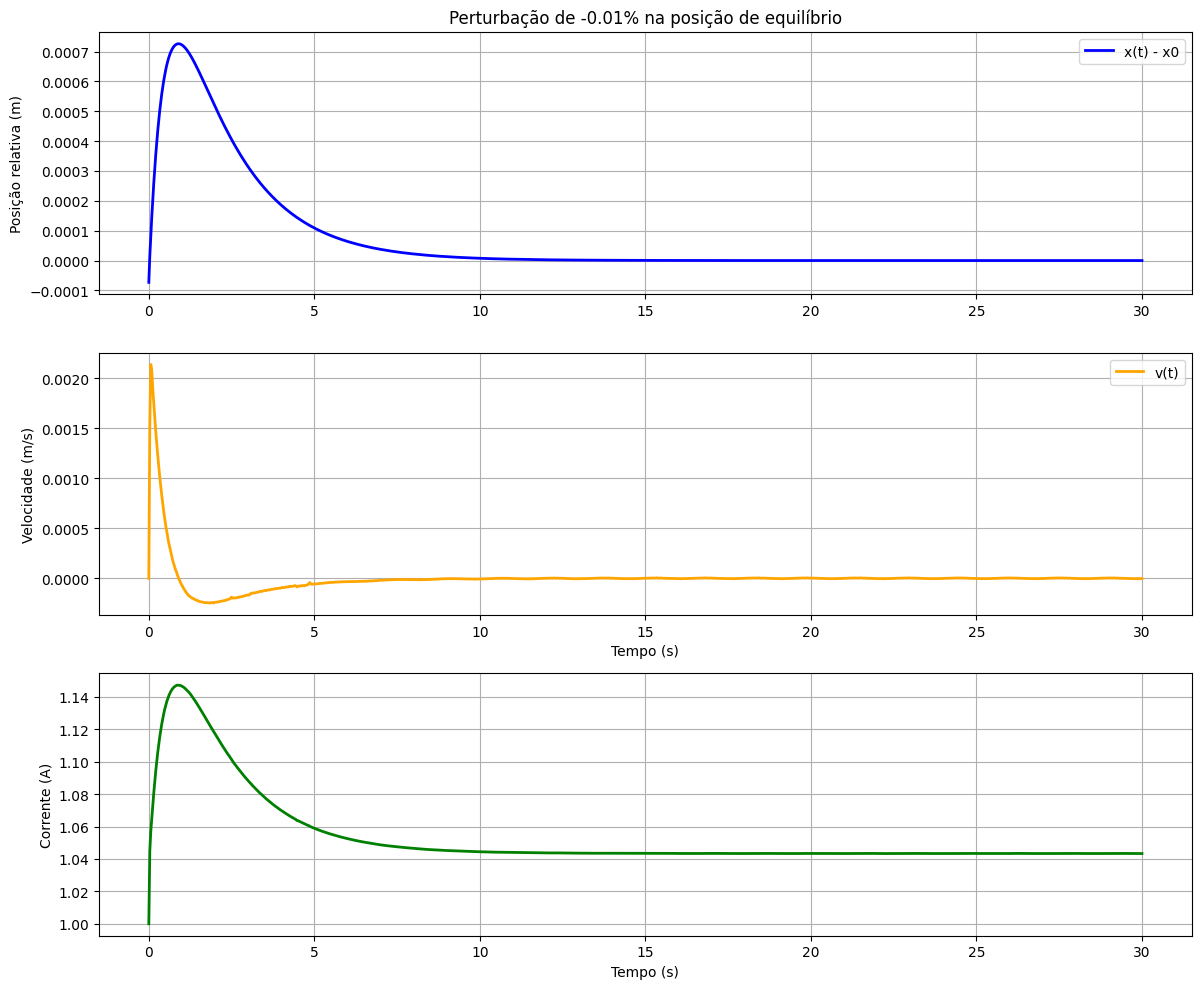

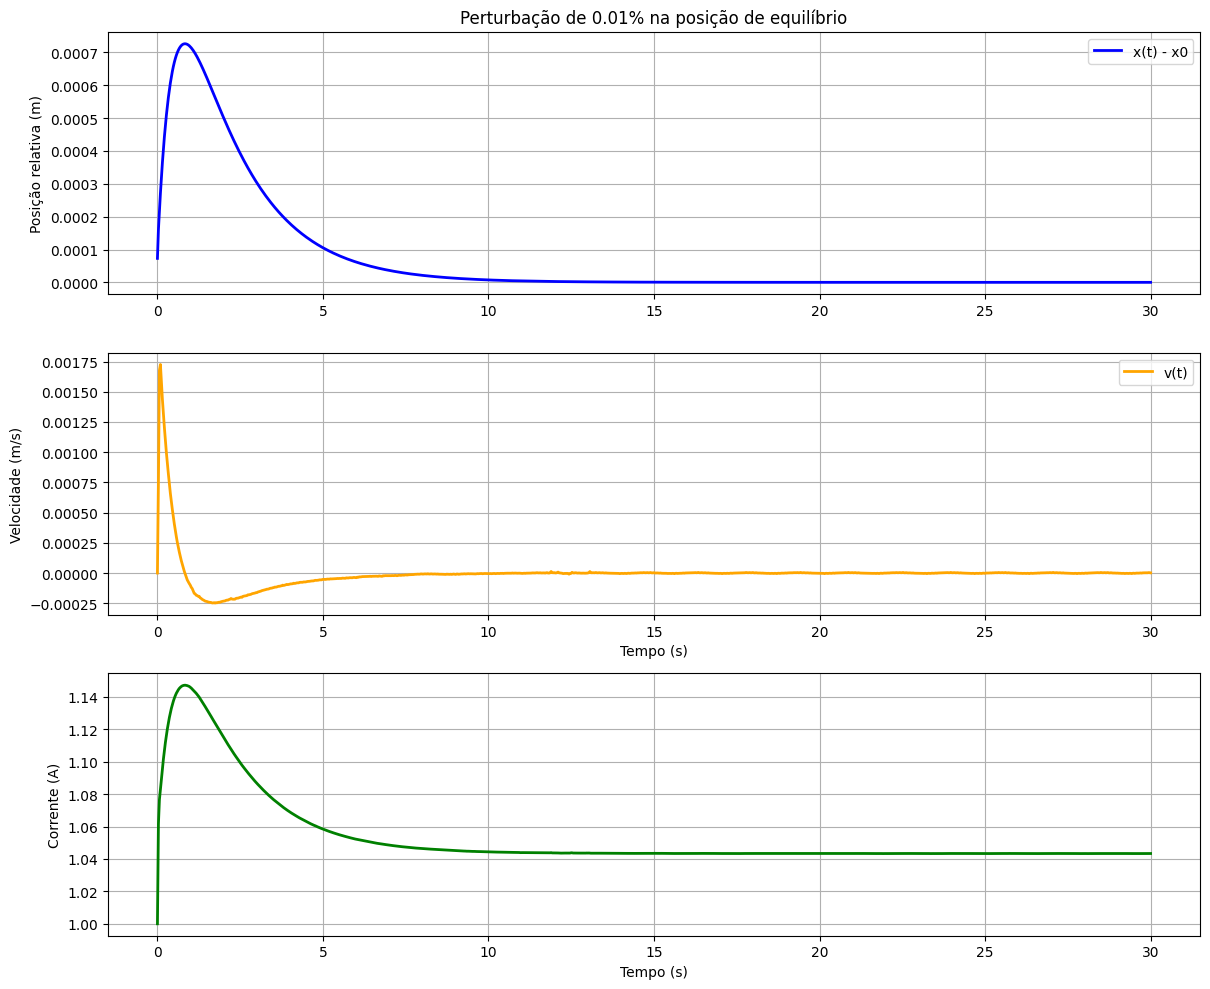

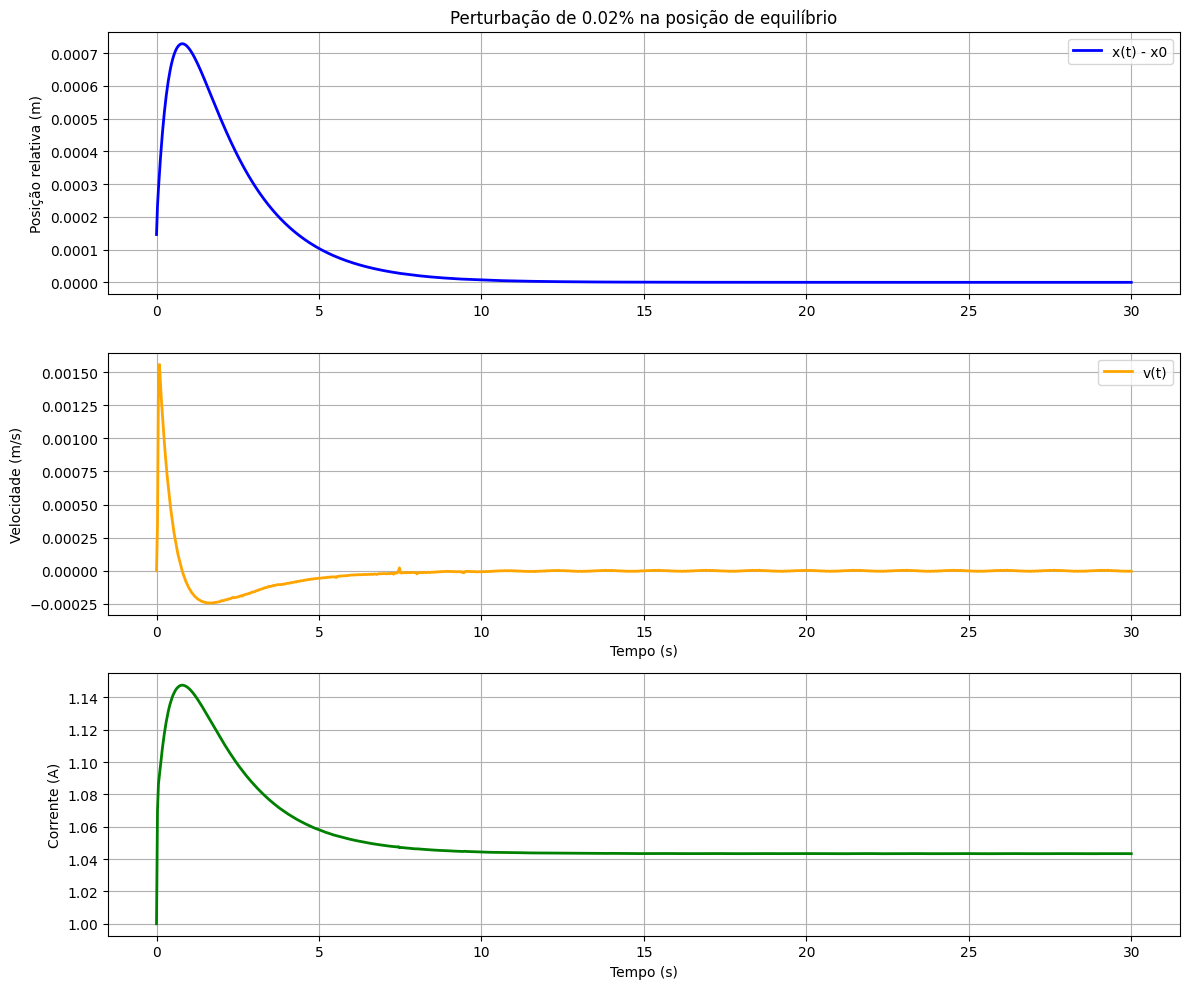

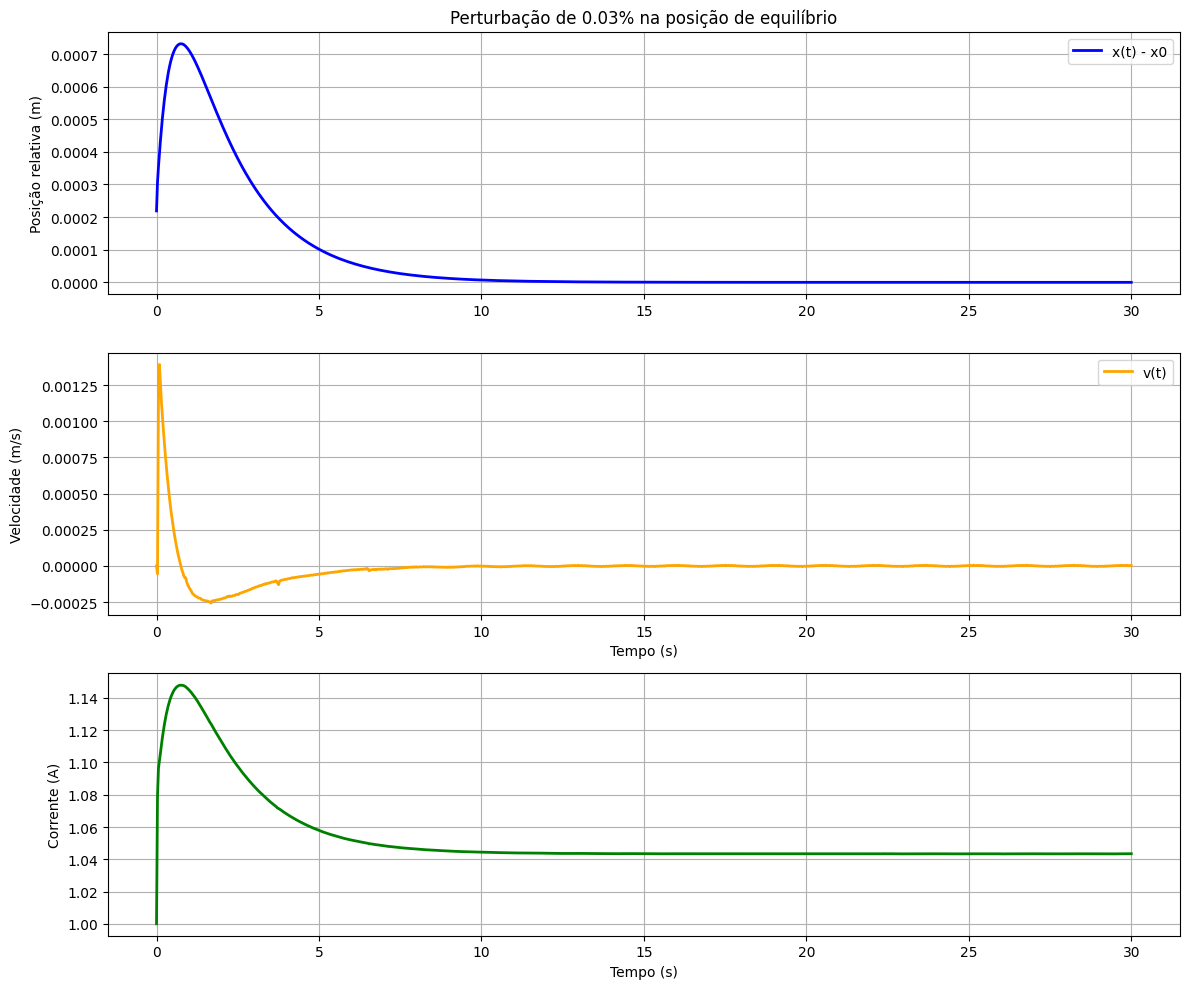

In [438]:
epsilons = [-0.03, -0.02, -0.01, 0.01, 0.02, 0.03]


# Ganhos do PID
Kp = 190
Ki = 20
Kd = 20

# Perturbação na resistência
for epsilon in epsilons:
        
    x0_perturbado = x0 * (1 + epsilon)

    # Condições iniciais
    y0 = [i0, x0_perturbado, 0.0, 0.0]  # [corrente, posição com erro, velocidade, erro acumulado]
    t0, tf = 0, 30           # intervalo de simulação
    t_eval = np.linspace(t0, tf, 1000)


    sol = solve_ivp(f, (t0, tf), y0, t_eval=t_eval)

    t = sol.t
    i = sol.y[0]
    x = sol.y[1]
    v = sol.y[2]
    
    i_max = np.max(i)
    
    fig, axs = plt.subplots(3, 1, figsize=(12, 10))
    
    axs[0].plot(t, x - x0, 'b', linewidth=2)  # diferença em relação ao x0 de equilíbrio
    axs[0].set_ylabel('Posição relativa (m)')
    axs[0].grid(True)
    axs[0].legend(['x(t) - x0'])
    axs[0].set_title(f'Perturbação de {epsilon}% na posição de equilíbrio')
    
    axs[1].plot(t, v, 'orange', linewidth=2)
    axs[1].set_ylabel('Velocidade (m/s)')
    axs[1].legend(['v(t)'])
    axs[1].set_xlabel('Tempo (s)')
    axs[1].grid(True)
    
    axs[2].plot(t, i, 'g', linewidth=2)
    axs[2].set_xlabel('Tempo (s)')
    axs[2].set_ylabel('Corrente (A)')
    axs[2].grid(True)
    
    plt.tight_layout()
    plt.show()
 

    